In [ ]:
"""Accounting methods

Generating P&L with different accounting methods (FIFO and LIFO)

Attributes
----------
cocoon
transaction configuration
derived portfolios
accounting methods
"""
## Import Libraries & Connect to LUSID

In [1]:
# Import LUSID
import lusid
import lusidtools.cocoon.cocoon as cocoon_tools
import lusid_sample_data as sd
from lusidjam import RefreshingToken
import pandas as pd
import numpy as np
import os
import pytz
import printer as prettyprint
from datetime import datetime
import pylab
import matplotlib.pyplot as plt

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

In [2]:
%matplotlib inline
%pylab inline

# Set style to fivethirtyeight to create clean and clear looking graphs
plt.style.use('fivethirtyeight')

# Define a dictionary containing default plotting configurations
params = {
    'legend.fontsize': 'small',
    'figure.figsize': (15, 10),
    'axes.labelsize': 'small',
    'axes.titlesize':'medium',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small'
}

pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


C:\Users\StephenLeMasney\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Import and Create Instruments

In [3]:
uk_instrument_master = pd.read_csv("data/global-fund-UK-instrument-master.csv")
uk_instrument_master.head(n=20)

instrument_name client_internal currency          isin  \
0                BP_LondonStockEx_BP    imd_43535553      GBP  GB0007980591   
1   BurfordCapital_LondonStockEx_BUR    imd_43534356      GBP  GG00B4L84979   
2   EKFDiagnostics_LondonStockEx_EKF    imd_34535355      GBP  GB0031509804   
3        Glencore_LondonStockEx_GLEN    imd_34534555      GBP  JE00B4T3BW64   
4           JustEat_LondonStockEx_JE    imd_35436366      GBP  GB00BKX5CN86   
5       Kingfisher_LondonStockEx_KGF    imd_34535552      GBP  GB0033195214   
6      MicroFocus_LondonStockEx_MCRO    imd_34567338      GBP  GB00BD8YWM01   
7        RELXGroup_LondonStockEx_REL    imd_43532542      GBP  GB00B2B0DG97   
8             Sage_LondonStockEx_SGE    imd_23536673      GBP  GB00B8C3BL03   
9           TESCO_LondonStockEx_TSCO    imd_34634673      GBP  GB0008847096   
10           UKGiltTreasury_2.0_2025    imd_34534536      GBP  GB00BTHH2R79   
11           UKGiltTreasury_3.5_2045    imd_54234532      GBP  GB00BN65R313   
12          UKGiltTreasury_3.75_2021    imd_34643653      GBP  GB00B4RMG977   
13           UKGiltTreasury_4.5_2034    imd_34534534      GBP  GB00B52WS153   
14             WPP_LondonStockEx_WPP    imd_34536734      GBP  JE00B8KF9B49   
15      Whitebread_LondonStockEx_WTB    imd_35349900      GBP  GB00B1KJJ408   
16                   TESCO_6.13_2022    imd_34001121      GBP  XS0414345974   

            figi exchange_code   country_issue             ticker  \
0   BBG000C05BD1            LN  united_kingdom                BP/   
1   BBG000PN88Q7            LN  united_kingdom                BUR   
2   BBG000BVNBN3            LN  united_kingdom                EKF   
3   BBG001MM1KV4            LN  united_kingdom               GLEN   
4   BBG0065YWM39            LN  united_kingdom                JE/   
5   BBG000BKH1W6            LN  united_kingdom                KGF   
6   BBG000G4KKD2            LN  united_kingdom               MCRO   
7   BBG000D03XD4            LN  united_kingdom                REL   
8   BBG000BN0PP3            LN  united_kingdom                SGE   
9   BBG000BF46Y8            LN  united_kingdom               TSCO   
10  BBG0088JSC32            LN  united_kingdom     UKT 2 09/07/25   
11  BBG006N6HZM7            LN  united_kingdom   UKT 3.5 01/22/45   
12  BBG001KKJLR4            LN  united_kingdom  UKT 3.75 09/07/21   
13  BBG0000D14P3            LN  united_kingdom   UKT 4.5 09/07/34   
14  BBG000BF6B57            LN  united_kingdom                WPP   
15  BBG000BRVH05            LN  united_kingdom                WTB   
16           NaN           NaN  united_kingdom                NaN   

   market_sector   security_type  coupon s&p rating  
0         equity    common_stock     nan        NaN  
1         equity    common_stock     nan        NaN  
2         equity    common_stock     nan        NaN  
3         equity    common_stock     nan        NaN  
4         equity    common_stock     nan        NaN  
5         equity    common_stock     nan        NaN  
6         equity    common_stock     nan        NaN  
7         equity    common_stock     nan        NaN  
8         equity    common_stock     nan        NaN  
9         equity    common_stock     nan        NaN  
10          govt   uk_gilt_stock    2.00         AA  
11          govt   uk_gilt_stock    3.50         AA  
12          govt   uk_gilt_stock    3.75         AA  
13          govt   uk_gilt_stock    4.50         AA  
14        equity    common_stock     nan        NaN  
15        equity    common_stock     nan        NaN  
16     corporate  corporate_bond    6.13         A-

In [4]:
instrument_properties_scope = 'InstrumentProperties005'

instrument_identifier_mapping = {
    "Figi": "figi",
    "Isin": "isin",
    "ClientInternal": "client_internal",
    "Ticker": "ticker"
}

instrument_mapping_required = {
    "name": "instrument_name"
}

instrument_mapping_optional = {}

responses = cocoon_tools.load_from_data_frame(
    api_factory=api_factory, 
    scope=instrument_properties_scope, 
    data_frame=uk_instrument_master, 
    mapping_required=instrument_mapping_required, 
    mapping_optional=instrument_mapping_optional, 
    file_type="instrument", 
    identifier_mapping=instrument_identifier_mapping, 
    property_columns=[
        "exchange_code", 
        "country_issue", 
        "market_sector",
        "security_type",
        "coupon",
        "s&p rating",
        "currency"])

prettyprint.instrument_response(responses["instruments"]["success"][0])

Instruments Successfully Upserted: 


Instrument ClientInternal ID LUSID Instrument ID
0   ClientInternal: imd_35436366      imd_35436366       LUID_GAEDQZEK
1   ClientInternal: imd_35349900      imd_35349900       LUID_ES78HCOF
2   ClientInternal: imd_34634673      imd_34634673       LUID_O8QAHSYW
3   ClientInternal: imd_34534536      imd_34534536       LUID_L3LCKX3E
4   ClientInternal: imd_34567338      imd_34567338       LUID_0DPVZGGH
5   ClientInternal: imd_34535355      imd_34535355       LUID_72N9ALQP
6   ClientInternal: imd_43532542      imd_43532542       LUID_TMIDV7PE
7   ClientInternal: imd_23536673      imd_23536673       LUID_T3PGABA5
8   ClientInternal: imd_54234532      imd_54234532       LUID_7ISQSZRL
9   ClientInternal: imd_34001121      imd_34001121       LUID_QEY5JRSL
10  ClientInternal: imd_43535553      imd_43535553       LUID_Y77EN6P0
11  ClientInternal: imd_34536734      imd_34536734       LUID_0J2DLUNT
12  ClientInternal: imd_34534555      imd_34534555       LUID_LGAOIPSM
13  ClientInternal: imd_34535552      imd_34535552       LUID_6O2RK906
14  ClientInternal: imd_43534356      imd_43534356       LUID_DFGJRAKV
15  ClientInternal: imd_34534534      imd_34534534       LUID_ITXY3Y1J
16  ClientInternal: imd_34643653      imd_34643653       LUID_Q2W9DXQ9

## Create a Portfolio with "FirstInFirstOut" (FIFO) Accounting Method

In [5]:
portfolio_code = "UK12XC2"

portfolio = pd.DataFrame([
    {
        "code": portfolio_code,
        "display_name": "UK Equity Fund",
        "description": "UK Growth Fund Trading in UK Tradeable Equities",
        "base_currency": "GBP",
        "accounting_method": "FirstInFirstOut",
        "created": datetime.datetime(year=2010, day=1, month=1, tzinfo=pytz.UTC)
    }
])

portfolio.head()

code    display_name                                      description  \
0  UK12XC2  UK Equity Fund  UK Growth Fund Trading in UK Tradeable Equities   

  base_currency accounting_method                   created  
0           GBP   FirstInFirstOut 2010-01-01 00:00:00+00:00

In [6]:
trading_scope = "AccountingDemoScope"

portfolio_mapping_required = {
    "code": "code",
    "display_name": "display_name",
    "base_currency": "base_currency",
    "accounting_method": "accounting_method"
}

portfolio_mapping_optional = {
    "description": "description",
    "created": "created"
}

responses = cocoon_tools.load_from_data_frame(
    api_factory=api_factory, 
    scope=trading_scope, 
    data_frame=portfolio, 
    mapping_required=portfolio_mapping_required, 
    mapping_optional=portfolio_mapping_optional, 
    file_type="portfolio")

prettyprint.portfolio_response(responses["portfolios"]["success"][0])

Portfolio Created
Scope: AccountingDemoScope
Code: UK12XC2
Portfolio Effective From: 2010-01-01 00:00:00+00:00
Portfolio Created On: 2020-03-25 11:16:52.694601+00:00



## Import and Create Transactions for September 2019

In [7]:
transactions = pd.read_csv("data/accounting-demo-sample-transactions.csv")
transactions["cash_transactions"] = np.where(transactions["desc"] == "FundsIn", transactions["trade_currency"], np.NaN) 
transactions.head(n=20)

desc        qty  unit_price trade_currency        exposure  \
0   FundsIn  900000000        1.00            GBP             NaN   
1       Buy     729176        5.92            GBP              BP   
2       Buy    1762711        8.85            GBP  BurfordCapital   
3       Buy   14087318        2.40            GBP        Glencore   
4       Buy     276624        7.42            GBP         JustEat   
5       Buy     500000       10.50            GBP      MicroFocus   
6       Buy     543176        5.10            GBP              BP   
7       Buy     853000        8.83            GBP  BurfordCapital   
8       Buy    9349219        2.41            GBP        Glencore   
9      Sell     854176        5.32            GBP              BP   
10     Sell     153000        7.33            GBP         JustEat   

    total_trade_amount figi_identifier                    trade_datetime  \
0          95000000.00             NaN  2019-09-01T09:31:22.664000+00:00   
1           3996759.49    BBG000C05BD1  2019-09-03T14:42:12.435000+00:00   
2          15599992.35    BBG000PN88Q7  2019-09-05T15:12:44.090000+00:00   
3          33879999.79    BBG001MM1KV4  2019-09-10T09:58:43.112000+00:00   
4           2051996.83    BBG0065YWM39  2019-09-10T13:58:57.113000+00:00   
5           5249000.00    BBG000G4KKD2  2019-09-12T15:32:57.113000+00:00   
6           2829240.83    BBG000C05BD1  2019-09-13T16:29:18.123000+00:00   
7           7531990.00    BBG000PN88Q7  2019-09-15T10:58:57.113000+00:00   
8          22503570.13    BBG001MM1KV4  2019-09-16T09:32:38.113000+00:00   
9           4548060.11    BBG000C05BD1  2019-09-19T09:32:38.113000+00:00   
10          1121459.40    BBG0065YWM39  2019-09-19T09:32:38.113000+00:00   

                 settlement_datetime isin_identifier  executor  \
0   2019-09-01T09:31:22.664000+00:00             NaN  jx112421   
1   2019-09-05T14:42:12.435000+00:00    GB0007980591  jx112421   
2   2019-09-07T15:12:44.090000+00:00    GG00B4L84979  jx112421   
3   2019-09-11T09:58:43.112000+00:00    JE00B4T3BW64  jx112421   
4   2019-09-11T13:58:57.113000+00:00    GB00BKX5CN86  jp392431   
5   2019-09-14T15:32:57.113000+00:00    GB00BD8YWM01  jx112421   
6   2019-09-15T16:29:18.123000+00:00    GB0007980591  jp392431   
7   2019-09-17T10:58:57.113000+00:00    GG00B4L84979  jx112421   
8   2019-09-18T09:32:38.113000+00:00    JE00B4T3BW64  jp392431   
9   2019-09-21T09:32:38.113000+00:00    GB0007980591  jp392431   
10  2019-09-21T09:32:38.113000+00:00    GB00BKX5CN86  jp392431   

                          asset_name fund_code                 t_id  \
0                                GBP   UK12XC2    kjk99898990z88908   
1                BP_LondonStockEx_BP   UK12XC2    435opkplk03sfsf33   
2   BurfordCapital_LondonStockEx_BUR   UK12XC2   dsfsdlkjs933234211   
3        Glencore_LondonStockEx_GLEN   UK12XC2   dfklsjd90232350239   
4            JustEat_LondonStockEx_J   UK12XC2  kj0llk90f0909201141   
5      MicroFocus_LondonStockEx_MCRO   UK12XC2   sadjkas934234sadfs   
6                BP_LondonStockEx_BP   UK12XC2   fas2340090sd9f0s23   
7   BurfordCapital_LondonStockEx_BUR   UK12XC2  dflkjsdflk932432rsd   
8        Glencore_LondonStockEx_GLEN   UK12XC2   sdfdslkf234092304s   
9                BP_LondonStockEx_BP   UK12XC2   2354lafjaso3432502   
10           JustEat_LondonStockEx_J   UK12XC2   sdlfksdlfk23409235   

   internal_identifier cash_transactions  
0                  NaN               GBP  
1         imd_43535553               NaN  
2         imd_43534356               NaN  
3         imd_34534555               NaN  
4         imd_35436366               NaN  
5         imd_34567338               NaN  
6         imd_43535553               NaN  
7         imd_43534356               NaN  
8         imd_34534555               NaN  
9         imd_43535553               NaN  
10        imd_35436366               NaN

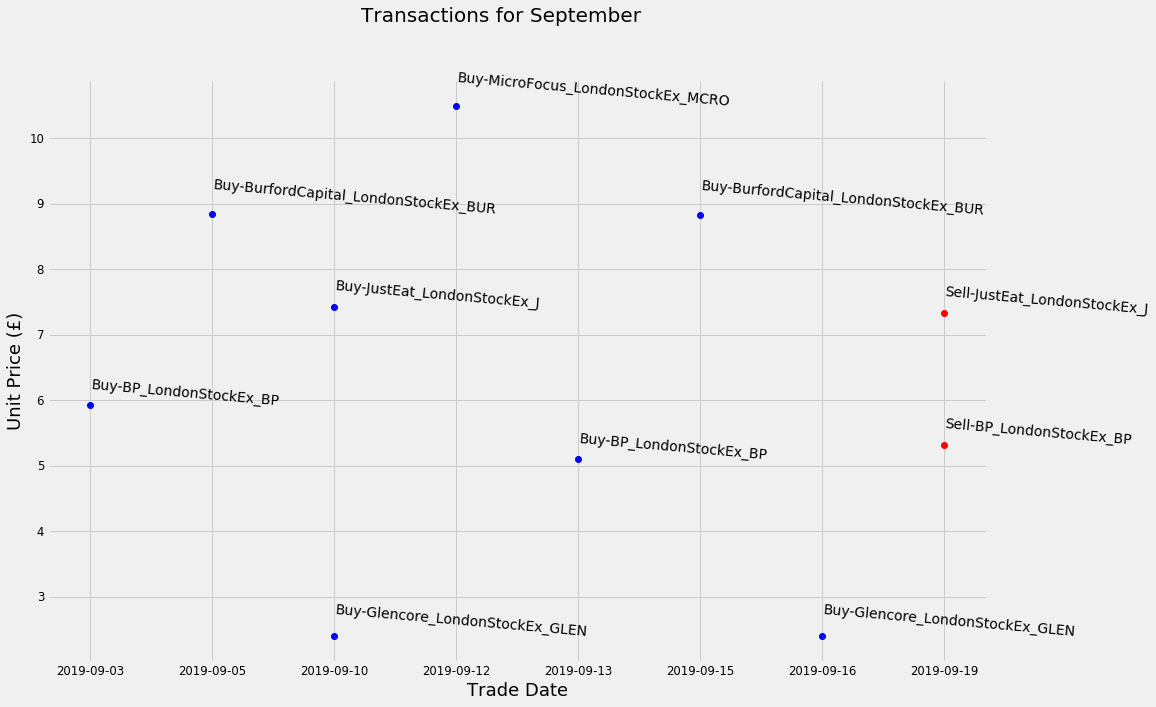

In [8]:
x = [date.split("T")[0] for date in transactions["trade_datetime"].values[1:]]
y = transactions["unit_price"].values[1:]
labels = [
    "-".join([
        transactions["desc"].values[i], 
        transactions["asset_name"].values[i]
    ]) for i in range(1, len(transactions["desc"].values))]

fig, ax = plt.subplots()
for x, y, label in zip(x,y,labels):
    if "Buy" in label:
        colour = "blue"
    else:
        colour = "red"

    ax.plot_date(x=x, y=y, c=colour)
    ax.annotate(label, (x, y), rotation=-5)

plt.xlabel('Trade Date', fontsize=18)
plt.ylabel('Unit Price (£)', fontsize=18)
fig.suptitle('Transactions for September', fontsize=20)
plt.show()

In [9]:
transaction_identifier_mapping = {
    "Figi": "figi_identifier",
    "Isin": "isin_identifier",
    "ClientInternal": "internal_identifier",
    "Currency": "cash_transactions"
}

transaction_mapping_required = {
    "code": "fund_code",
    "transaction_id": "t_id",
    "type": "desc",
    "transaction_date": "trade_datetime",
    "settlement_date": "settlement_datetime",
    "units": "qty",
    "transaction_price.price": "unit_price",
    "transaction_price.type": "$Price",
    "total_consideration.amount": "total_trade_amount",
    "total_consideration.currency": "trade_currency"
}

transaction_mapping_optional = {
    "exchange_rate": "$1",
    "transaction_currency": "trade_currency"
}

responses = cocoon_tools.load_from_data_frame(
    api_factory=api_factory, 
    scope=trading_scope, 
    data_frame=transactions, 
    mapping_required=transaction_mapping_required, 
    mapping_optional=transaction_mapping_optional, 
    file_type="transactions", 
    identifier_mapping=transaction_identifier_mapping, 
    property_columns=[
        "exposure",
        "executor",
        "asset_name"
    ])

prettyprint.transactions_response(
    responses["transactions"]["success"][0], 
    trading_scope, 
    responses["transactions"]["success"][0].href.split("/")[7])

Transactions Successfully Upserted into Portfolio
Scope: AccountingDemoScope
Code: UK12XC2
Transactions Effective From: 2019-09-19 09:32:38.113000+00:00
Transactions Created On: 2020-03-25 11:16:56.084142+00:00



## List Transaction Types

In [10]:
# Call LUSID to get your transaction type configuration
response = api_factory.build(lusid.api.SystemConfigurationApi).list_configuration_transaction_types()
# Pretty print the configuration
prettyprint.transaction_type_response(response, filters=["Buy", "Sell", "FundsIn"])

Transaction Configuration #1

Transaction Type Aliases
Transaction Type: Buy
Alias Description: Purchase
Transaction Class: Basic
Transaction Group: default
Transaction Roles: LongLonger


Transaction Movements
Movement Types: StockMovement
Side: Side1
Direction: 1
Movement Types: CashCommitment
Side: Side2
Direction: -1



Transaction Configuration #2

Transaction Type Aliases
Transaction Type: Sell
Alias Description: Sale
Transaction Class: Basic
Transaction Group: default
Transaction Roles: LongShorter


Transaction Movements
Movement Types: StockMovement
Side: Side1
Direction: -1
Movement Types: CashCommitment
Side: Side2
Direction: 1



Transaction Configuration #13

Transaction Type Aliases
Transaction Type: FundsIn
Alias Description: Deposit New Funds
Transaction Class: CashTransfers
Transaction Group: default
Transaction Roles: Longer


Transaction Movements
Movement Types: CashReceivable
Side: Side1
Direction: 1





## Generate Holdings by Tax Lot At 30th September 2019

In [11]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).get_holdings(
    scope=trading_scope,
    code=portfolio_code,
    property_keys=[
        "Instrument/default/Name",
        "Instrument/default/Figi",
        f"Instrument/{instrument_properties_scope}/security_type"
    ],
    by_taxlots=True,
    effective_at=datetime.datetime(year=2019, month=9, day=30, hour=12, tzinfo=pytz.UTC))

prettyprint.get_holdings_df(response)

_instrument_uid _holding_type       _units  _settled_units _transaction  \
0   LUID_Y77EN6P0             P    418176.00       418176.00         None   
1   LUID_DFGJRAKV             P   1762711.00      1762711.00         None   
2   LUID_DFGJRAKV             P    853000.00       853000.00         None   
3   LUID_LGAOIPSM             P  14087318.00     14087318.00         None   
4   LUID_LGAOIPSM             P   9349219.00      9349219.00         None   
5   LUID_GAEDQZEK             P    123624.00       123624.00         None   
6   LUID_0DPVZGGH             P    500000.00       500000.00         None   
7         CCY_GBP             B 812026970.09    812026970.09         None   

  discriminator  cost.amount cost.currency  cost_portfolio_ccy.amount  \
0          None   2178153.33           GBP                 2178153.33   
1          None  15599992.35           GBP                15599992.35   
2          None   7531990.00           GBP                 7531990.00   
3          None  33879999.79           GBP                33879999.79   
4          None  22503570.13           GBP                22503570.13   
5          None    917042.83           GBP                  917042.83   
6          None   5249000.00           GBP                 5249000.00   
7          None 812026970.09           GBP               812026970.09   

  Holding/default/TaxlotPurchaseDate  Holding/default/TaxlotPurchasePrice  \
0  2019-09-13T16:29:18.1230000+00:00                                 5.10   
1  2019-09-05T15:12:44.0900000+00:00                                 8.85   
2  2019-09-15T10:58:57.1130000+00:00                                 8.83   
3  2019-09-10T09:58:43.1120000+00:00                                 2.40   
4  2019-09-16T09:32:38.1130000+00:00                                 2.41   
5  2019-09-10T13:58:57.1130000+00:00                                 7.42   
6  2019-09-12T15:32:57.1130000+00:00                                10.50   
7                                NaN                                  nan   

            Instrument/default/Name Instrument/default/Figi  \
0               BP_LondonStockEx_BP            BBG000C05BD1   
1  BurfordCapital_LondonStockEx_BUR            BBG000PN88Q7   
2  BurfordCapital_LondonStockEx_BUR            BBG000PN88Q7   
3       Glencore_LondonStockEx_GLEN            BBG001MM1KV4   
4       Glencore_LondonStockEx_GLEN            BBG001MM1KV4   
5          JustEat_LondonStockEx_JE            BBG0065YWM39   
6     MicroFocus_LondonStockEx_MCRO            BBG000G4KKD2   
7                           CCY_GBP                     NaN   

  Instrument/InstrumentProperties005/security_type  
0                                     common_stock  
1                                     common_stock  
2                                     common_stock  
3                                     common_stock  
4                                     common_stock  
5                                     common_stock  
6                                     common_stock  
7                                              NaN

## Generate P/L for September 2019

In [12]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).build_transactions(
    scope=trading_scope,
    code=portfolio_code,
    query_parameters=lusid.models.TransactionQueryParameters(
        start_date=datetime.datetime(year=2019, month=9, day=1, hour=0, tzinfo=pytz.UTC),
        end_date=datetime.datetime(year=2019, month=9, day=30, hour=0, tzinfo=pytz.UTC),
        query_mode="TradeDate"
        )
    )

profit_loss_fifo = prettyprint.output_transactions(response, trading_scope, portfolio_code)
profit_loss_fifo["accounting_method"] = "FIFO"
profit_loss_fifo

Output Transactions for Portfolio
Scope: AccountingDemoScope
Code: UK12XC2



Transaction ID Transaction Type  \
0    2354lafjaso3432502             Sell   
1    sdlfksdlfk23409235             Sell   
2     435opkplk03sfsf33              Buy   
3    dsfsdlkjs933234211              Buy   
4    dfklsjd90232350239              Buy   
5   kj0llk90f0909201141              Buy   
6    sadjkas934234sadfs              Buy   
7    fas2340090sd9f0s23              Buy   
8   dflkjsdflk932432rsd              Buy   
9    sdfdslkf234092304s              Buy   
10    kjk99898990z88908          FundsIn   
11                  NaN              NaN   

   Transaction/AccountingDemoScope/exposure  \
0                                        BP   
1                                   JustEat   
2                                        BP   
3                            BurfordCapital   
4                                  Glencore   
5                                   JustEat   
6                                MicroFocus   
7                                        BP   
8                            BurfordCapital   
9                                  Glencore   
10                                 jx112421   
11                                      NaN   

   Transaction/AccountingDemoScope/executor  \
0                                  jp392431   
1                                  jp392431   
2                                  jx112421   
3                                  jx112421   
4                                  jx112421   
5                                  jp392431   
6                                  jx112421   
7                                  jp392431   
8                                  jx112421   
9                                  jp392431   
10                                      GBP   
11                                      NaN   

   Transaction/AccountingDemoScope/asset_name  \
0                         BP_LondonStockEx_BP   
1                     JustEat_LondonStockEx_J   
2                         BP_LondonStockEx_BP   
3            BurfordCapital_LondonStockEx_BUR   
4                 Glencore_LondonStockEx_GLEN   
5                     JustEat_LondonStockEx_J   
6               MicroFocus_LondonStockEx_MCRO   
7                         BP_LondonStockEx_BP   
8            BurfordCapital_LondonStockEx_BUR   
9                 Glencore_LondonStockEx_GLEN   
10       ccab228b-77d6-4b74-9f42-28c5413b8f09   
11                                        NaN   

   Transaction/default/SourcePortfolioId  \
0   ccab228b-77d6-4b74-9f42-28c5413b8f09   
1   ccab228b-77d6-4b74-9f42-28c5413b8f09   
2   ccab228b-77d6-4b74-9f42-28c5413b8f09   
3   ccab228b-77d6-4b74-9f42-28c5413b8f09   
4   ccab228b-77d6-4b74-9f42-28c5413b8f09   
5   ccab228b-77d6-4b74-9f42-28c5413b8f09   
6   ccab228b-77d6-4b74-9f42-28c5413b8f09   
7   ccab228b-77d6-4b74-9f42-28c5413b8f09   
8   ccab228b-77d6-4b74-9f42-28c5413b8f09   
9   ccab228b-77d6-4b74-9f42-28c5413b8f09   
10                   AccountingDemoScope   
11                                   NaN   

   Transaction/default/SourcePortfolioScope  \
0                       AccountingDemoScope   
1                       AccountingDemoScope   
2                       AccountingDemoScope   
3                       AccountingDemoScope   
4                       AccountingDemoScope   
5                       AccountingDemoScope   
6                       AccountingDemoScope   
7                       AccountingDemoScope   
8                       AccountingDemoScope   
9                       AccountingDemoScope   
10                             900000000.00   
11                                      NaN   

    Transaction/default/ResultantHolding       Units  \
0                                    nan   854176.00   
1                                    nan   153000.00   
2                                    nan   729176.00   
3                                    nan  1762711.00   
4                                    nan 14087318.00   
5                                    nan   276624.00 

## Create Derived Portfolio with "LastInFirstOut" accounting method and Generate P/L

In [13]:
try:
    response = api_factory.build(lusid.api.PortfoliosApi).get_portfolio(
        scope=trading_scope,
        code=portfolio_code+"LIFO")
    
except lusid.exceptions.ApiException as e:
    if e.status == 404:
        response = api_factory.build(lusid.api.DerivedTransactionPortfoliosApi).create_derived_portfolio(
            scope=trading_scope,
            portfolio=lusid.models.CreateDerivedTransactionPortfolioRequest(
                code=portfolio_code+"LIFO",
                display_name="LIFO Accounting treatment for the fund",
                parent_portfolio_id=lusid.models.ResourceId(
                    scope=trading_scope,
                    code=portfolio_code),
                accounting_method="LastInFirstOut",
                created=datetime.datetime(year=2010, month=1, day=1, tzinfo=pytz.UTC)
            )
        )

prettyprint.portfolio_response(response)

Derived Portfolio Created
Scope: AccountingDemoScope
Code: UK12XC2LIFO
Portfolio Effective From: 2010-01-01 00:00:00+00:00
Portfolio Created On: 2020-03-25 11:16:57.995460+00:00

   Parent Portfolio Details
   Scope: AccountingDemoScope
   Code: UK12XC2



In [14]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).build_transactions(
    scope=trading_scope,
    code=portfolio_code+"LIFO",
    query_parameters=lusid.models.TransactionQueryParameters(
        start_date=datetime.datetime(year=2019, month=9, day=1, hour=0, tzinfo=pytz.UTC),
        end_date=datetime.datetime(year=2019, month=9, day=30, hour=0, tzinfo=pytz.UTC),
        query_mode="TradeDate"
        )
    )

profit_loss_lifo = prettyprint.output_transactions(response, trading_scope, portfolio_code+"LIFO")
profit_loss_lifo["accounting_method"] = "LIFO"
profit_loss_lifo

Output Transactions for Portfolio
Scope: AccountingDemoScope
Code: UK12XC2LIFO



Transaction ID Transaction Type  \
0    sdlfksdlfk23409235             Sell   
1    2354lafjaso3432502             Sell   
2     435opkplk03sfsf33              Buy   
3    dsfsdlkjs933234211              Buy   
4    dfklsjd90232350239              Buy   
5   kj0llk90f0909201141              Buy   
6    sadjkas934234sadfs              Buy   
7    fas2340090sd9f0s23              Buy   
8   dflkjsdflk932432rsd              Buy   
9    sdfdslkf234092304s              Buy   
10    kjk99898990z88908          FundsIn   
11                  NaN              NaN   

   Transaction/AccountingDemoScope/exposure  \
0                                   JustEat   
1                                        BP   
2                                        BP   
3                            BurfordCapital   
4                                  Glencore   
5                                   JustEat   
6                                MicroFocus   
7                                        BP   
8                            BurfordCapital   
9                                  Glencore   
10                                 jx112421   
11                                      NaN   

   Transaction/AccountingDemoScope/executor  \
0                                  jp392431   
1                                  jp392431   
2                                  jx112421   
3                                  jx112421   
4                                  jx112421   
5                                  jp392431   
6                                  jx112421   
7                                  jp392431   
8                                  jx112421   
9                                  jp392431   
10                                      GBP   
11                                      NaN   

   Transaction/AccountingDemoScope/asset_name  \
0                     JustEat_LondonStockEx_J   
1                         BP_LondonStockEx_BP   
2                         BP_LondonStockEx_BP   
3            BurfordCapital_LondonStockEx_BUR   
4                 Glencore_LondonStockEx_GLEN   
5                     JustEat_LondonStockEx_J   
6               MicroFocus_LondonStockEx_MCRO   
7                         BP_LondonStockEx_BP   
8            BurfordCapital_LondonStockEx_BUR   
9                 Glencore_LondonStockEx_GLEN   
10       6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
11                                        NaN   

   Transaction/default/SourcePortfolioId  \
0   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
1   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
2   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
3   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
4   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
5   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
6   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
7   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
8   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
9   6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
10                   AccountingDemoScope   
11                                   NaN   

   Transaction/default/SourcePortfolioScope  \
0                       AccountingDemoScope   
1                       AccountingDemoScope   
2                       AccountingDemoScope   
3                       AccountingDemoScope   
4                       AccountingDemoScope   
5                       AccountingDemoScope   
6                       AccountingDemoScope   
7                       AccountingDemoScope   
8                       AccountingDemoScope   
9                       AccountingDemoScope   
10                             900000000.00   
11                                      NaN   

    Transaction/default/ResultantHolding       Units  \
0                                    nan   153000.00   
1                                    nan   854176.00   
2                                    nan   729176.00   
3                                    nan  1762711.00   
4                                    nan 14087318.00   
5                                    nan   276624.00 

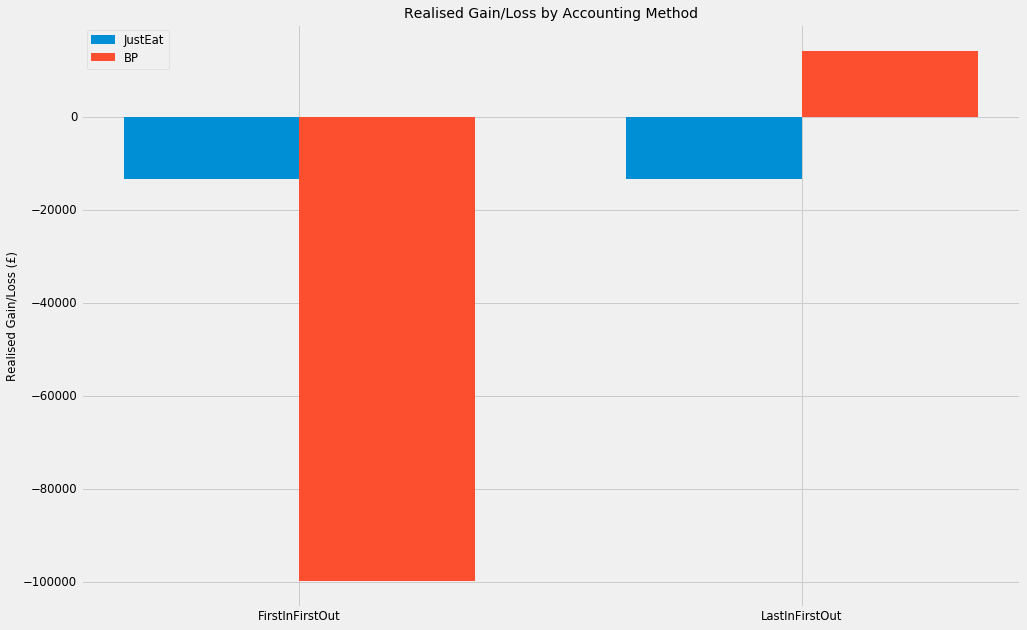

Transaction ID Transaction Type  \
0  2354lafjaso3432502             Sell   
1  sdlfksdlfk23409235             Sell   
0  sdlfksdlfk23409235             Sell   
1  2354lafjaso3432502             Sell   

  Transaction/AccountingDemoScope/exposure  \
0                                       BP   
1                                  JustEat   
0                                  JustEat   
1                                       BP   

  Transaction/AccountingDemoScope/executor  \
0                                 jp392431   
1                                 jp392431   
0                                 jp392431   
1                                 jp392431   

  Transaction/AccountingDemoScope/asset_name  \
0                        BP_LondonStockEx_BP   
1                    JustEat_LondonStockEx_J   
0                    JustEat_LondonStockEx_J   
1                        BP_LondonStockEx_BP   

  Transaction/default/SourcePortfolioId  \
0  ccab228b-77d6-4b74-9f42-28c5413b8f09   
1  ccab228b-77d6-4b74-9f42-28c5413b8f09   
0  6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   
1  6dd1cc2e-ee91-4cf0-a8a3-163855ed6366   

  Transaction/default/SourcePortfolioScope  \
0                      AccountingDemoScope   
1                      AccountingDemoScope   
0                      AccountingDemoScope   
1                      AccountingDemoScope   

   Transaction/default/ResultantHolding     Units Price Currency  \
0                                   nan 854176.00  5.32      GBP   
1                                   nan 153000.00  7.33      GBP   
0                                   nan 153000.00  7.33      GBP   
1                                   nan 854176.00  5.32      GBP   

                   Transaction Date                   Settlement Date  \
0  2019-09-19 09:32:38.113000+00:00  2019-09-21 09:32:38.113000+00:00   
1  2019-09-19 09:32:38.113000+00:00  2019-09-21 09:32:38.113000+00:00   
0  2019-09-19 09:32:38.113000+00:00  2019-09-21 09:32:38.113000+00:00   
1  2019-09-19 09:32:38.113000+00:00  2019-09-21 09:32:38.113000+00:00   

   Realised Gain Loss accounting_method  
0           -99786.88              FIFO  
1           -13494.60              FIFO  
0           -13494.60              LIFO  
1            14166.08              LIFO

In [15]:
profit_loss_both = pd.concat([profit_loss_lifo, profit_loss_fifo]) \
                   .dropna(subset=["Realised Gain Loss", "Transaction ID"], axis=0) \
                   .sort_values("accounting_method")

x = np.arange(len(profit_loss_both["accounting_method"].unique()))
gain_loss_just_eat = profit_loss_both.loc[
    profit_loss_both["Transaction/AccountingDemoScope/exposure"] == "JustEat", "Realised Gain Loss"].unique()
gain_loss_bp = profit_loss_both.loc[
    profit_loss_both["Transaction/AccountingDemoScope/exposure"] == "BP", "Realised Gain Loss"].unique()
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, gain_loss_just_eat, width, label='JustEat')
rects2 = ax.bar(x + width/2, gain_loss_bp, width, label='BP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Realised Gain/Loss (£)')
ax.set_title('Realised Gain/Loss by Accounting Method')
ax.set_xticks(x)
ax.set_xticklabels(["FirstInFirstOut", "LastInFirstOut"])
ax.legend()
plt.show()
profit_loss_both